In [28]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

pd.set_option('display.max_rows',10000)
pd.set_option('display.min_rows',2000)
pd.set_option('display.column_space',30)
pd.set_option('display.max_colwidth',150)
pd.set_option('display.expand_frame_repr',True)

_end_dates    = pd.Series(pd.date_range(start="2020-10-08", end="2021-03-31", freq="D", tz='America/New_York'))
_start_dates  = _end_dates - pd.Timedelta(days=7)
_center_dates = _end_dates - pd.Timedelta(days=3.5)
end_dates     = _end_dates.apply(lambda x: x.timestamp())
center_dates  = _center_dates.apply(lambda x: x.timestamp())
start_dates   = _start_dates.apply(lambda x: x.timestamp())
_end_dates    = _end_dates.apply(lambda x:str(x).split(' ')[0])
_center_dates = _center_dates.apply(lambda x:str(x).split(' ')[0])
_start_dates  = _start_dates.apply(lambda x:str(x).split(' ')[0])

id_l = '/home/casonk/path/mmani_root/mmani0/shared_data/hot/push_file/IDL/'

j=1
k=21
r=10

In [2]:
def covariance(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    denominator = len(x)-1
    cov = numerator/denominator
    return cov

In [3]:
def correlation(x, y):
    # Finding the mean of the series x and y
    mean_x = sum(x)/float(len(x))
    mean_y = sum(y)/float(len(y))
    # Subtracting mean from the individual elements
    sub_x = [i-mean_x for i in x]
    sub_y = [i-mean_y for i in y]
    # covariance for x and y
    numerator = sum([sub_x[i]*sub_y[i] for i in range(len(sub_x))])
    # Standard Deviation of x and y
    std_deviation_x = sum([sub_x[i]**2.0 for i in range(len(sub_x))])
    std_deviation_y = sum([sub_y[i]**2.0 for i in range(len(sub_y))])
    # squaring by 0.5 to find the square root
    denominator = (std_deviation_x*std_deviation_y)**0.5 # short but equivalent to (std_deviation_x**0.5) * (std_deviation_y**0.5)
    cor = numerator/denominator
    return cor

In [ ]:
conservative_tl = []
conservative_ei = []
conservative_dt = []
n=1
# n=10
for date in _center_dates:
    ei_df = pd.read_pickle((id_l + date + ('/EI_DF_{}_{}_{}.pkl').format(j, k, r)))
    top_75 = ei_df.sort_values(by=['Total_Links'], ascending=False).head(75)
    comm_sub_pairs = pd.read_pickle((id_l + date + ('/CSP_{}_{}_{}.pkl').format(j, k, r)))
    top_ns_75 = comm_sub_pairs.loc[top_75.index].groupby(level=0, axis=0).apply(lambda x : x.head(n)).droplevel(0)
    coms = top_ns_75.index.get_level_values(0)
    subs = top_ns_75.index.get_level_values(1)
    dekka = pd.DataFrame({'com':coms, 'sub':subs})
    insubs = ['conservative']
    match = dekka[dekka['sub'].isin(insubs)]
    if len(match['com'].unique()) == 1:
        incom = int(match['com'].unique()[0])
        conservative_tl += [ei_df.loc[incom, ['Total_Links','EI_Index']][0]]
        conservative_ei += [ei_df.loc[incom, ['Total_Links','EI_Index']][1]]
        conservative_dt += [date]
        print(date, incom)
    else:
        print('**', date, len(match['com'].unique()), 'comm')

In [ ]:
neoliberal_tl = []
neoliberal_ei = []
neoliberal_dt = []
n=2
for date in _center_dates:
    ei_df = pd.read_pickle((id_l + date + ('/EI_DF_{}_{}_{}.pkl').format(j, k, r)))
    top_75 = ei_df.sort_values(by=['Total_Links'], ascending=False).head(300)
    comm_sub_pairs = pd.read_pickle((id_l + date + ('/CSP_{}_{}_{}.pkl').format(j, k, r)))
    top_ns_75 = comm_sub_pairs.loc[top_75.index].groupby(level=0, axis=0).apply(lambda x : x.head(n)).droplevel(0)
    coms = top_ns_75.index.get_level_values(0)
    subs = top_ns_75.index.get_level_values(1)
    dekka = pd.DataFrame({'com':coms, 'sub':subs})
    insubs = ['neoliberal']
    match = dekka[dekka['sub'].isin(insubs)]
    if len(match['com'].unique()) == 1:
        incom = int(match['com'].unique()[0])
        neoliberal_tl += [ei_df.loc[incom, ['Total_Links','EI_Index']][0]]
        neoliberal_ei += [ei_df.loc[incom, ['Total_Links','EI_Index']][1]]
        neoliberal_dt += [date]
        print(date, incom)
    else:
        print('**', date, len(match['com'].unique()), 'comm')

In [7]:
pairs = set(conservative_dt).intersection(set(neoliberal_dt))

In [8]:
conservative = {}
i = 0
for date in conservative_dt:
    if date in pairs:
        conservative[date] = conservative_ei[i]
    i += 1
neoliberal = {}
i = 0
for date in neoliberal_dt:
    if date in pairs:
        neoliberal[date] = neoliberal_ei[i]
    i += 1

In [9]:
covariance(conservative.values(), neoliberal.values())

0.002753107187712047

In [10]:
correlation(conservative.values(), neoliberal.values())

0.4732014012813691

In [44]:
stats.pearsonr(list(conservative.values()), list(neoliberal.values()))

(0.47320140128136917, 1.5673609872271928e-10)

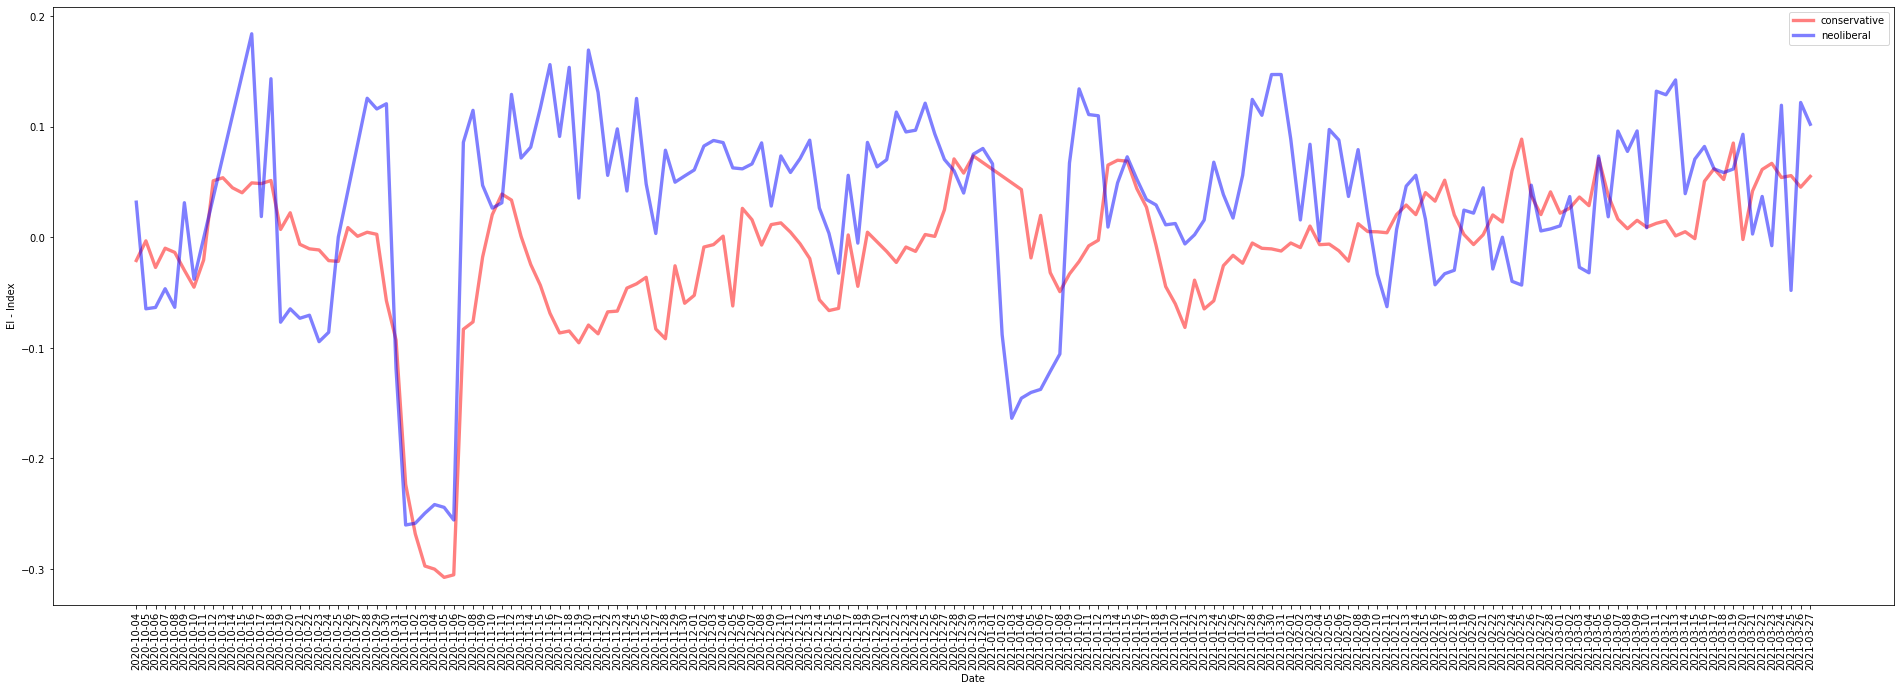

In [ ]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(conservative.keys(), conservative.values(), c='red', lw=3.333, alpha=0.5, label='conservative')
plt.plot(neoliberal.keys(), neoliberal.values(), c='blue', lw=3.333, alpha=0.5, label='neoliberal')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

In [ ]:
politics_tl = []
politics_ei = []
politics_dt = []
n=1
# n=10
for date in _center_dates:
    ei_df = pd.read_pickle((id_l + date + ('/EI_DF_{}_{}_{}.pkl').format(j, k, r)))
    top_75 = ei_df.sort_values(by=['Total_Links'], ascending=False).head(75)
    comm_sub_pairs = pd.read_pickle((id_l + date + ('/CSP_{}_{}_{}.pkl').format(j, k, r)))
    top_ns_75 = comm_sub_pairs.loc[top_75.index].groupby(level=0, axis=0).apply(lambda x : x.head(n)).droplevel(0)
    coms = top_ns_75.index.get_level_values(0)
    subs = top_ns_75.index.get_level_values(1)
    dekka = pd.DataFrame({'com':coms, 'sub':subs})
    insubs = ['politics']
    match = dekka[dekka['sub'].isin(insubs)]
    if len(match['com'].unique()) == 1:
        incom = int(match['com'].unique()[0])
        politics_tl += [ei_df.loc[incom, ['Total_Links','EI_Index']][0]]
        politics_ei += [ei_df.loc[incom, ['Total_Links','EI_Index']][1]]
        politics_dt += [date]
        print(date, incom)
    else:
        print('**', date, len(match['com'].unique()), 'comm')

In [ ]:
ukpolitics_tl = []
ukpolitics_ei = []
ukpolitics_dt = []
n=3
# n=10
for date in _center_dates:
    ei_df = pd.read_pickle((id_l + date + ('/EI_DF_{}_{}_{}.pkl').format(j, k, r)))
    top_75 = ei_df.sort_values(by=['Total_Links'], ascending=False).head(75)
    comm_sub_pairs = pd.read_pickle((id_l + date + ('/CSP_{}_{}_{}.pkl').format(j, k, r)))
    top_ns_75 = comm_sub_pairs.loc[top_75.index].groupby(level=0, axis=0).apply(lambda x : x.head(n)).droplevel(0)
    coms = top_ns_75.index.get_level_values(0)
    subs = top_ns_75.index.get_level_values(1)
    dekka = pd.DataFrame({'com':coms, 'sub':subs})
    insubs = ['ukpolitics']
    match = dekka[dekka['sub'].isin(insubs)]
    if len(match['com'].unique()) == 1:
        incom = int(match['com'].unique()[0])
        ukpolitics_tl += [ei_df.loc[incom, ['Total_Links','EI_Index']][0]]
        ukpolitics_ei += [ei_df.loc[incom, ['Total_Links','EI_Index']][1]]
        ukpolitics_dt += [date]
        print(date, incom)
    else:
        print('**', date, len(match['com'].unique()), 'comm')

In [48]:
pairs = set(politics_dt).intersection(set(ukpolitics_dt))

In [49]:
politics = {}
i = 0
for date in politics_dt:
    if date in pairs:
        politics[date] = politics_ei[i]
    i += 1
ukpolitics = {}
i = 0
for date in ukpolitics_dt:
    if date in pairs:
        ukpolitics[date] = ukpolitics_ei[i]
    i += 1

In [ ]:
covariance(politics.values(), ukpolitics.values())

0.0006288119352727417

In [ ]:
correlation(politics.values(), ukpolitics.values())

0.376643092750627

In [50]:
stats.pearsonr(list(politics.values()), list(ukpolitics.values()))

(0.37664309275062663, 6.668377574451987e-07)

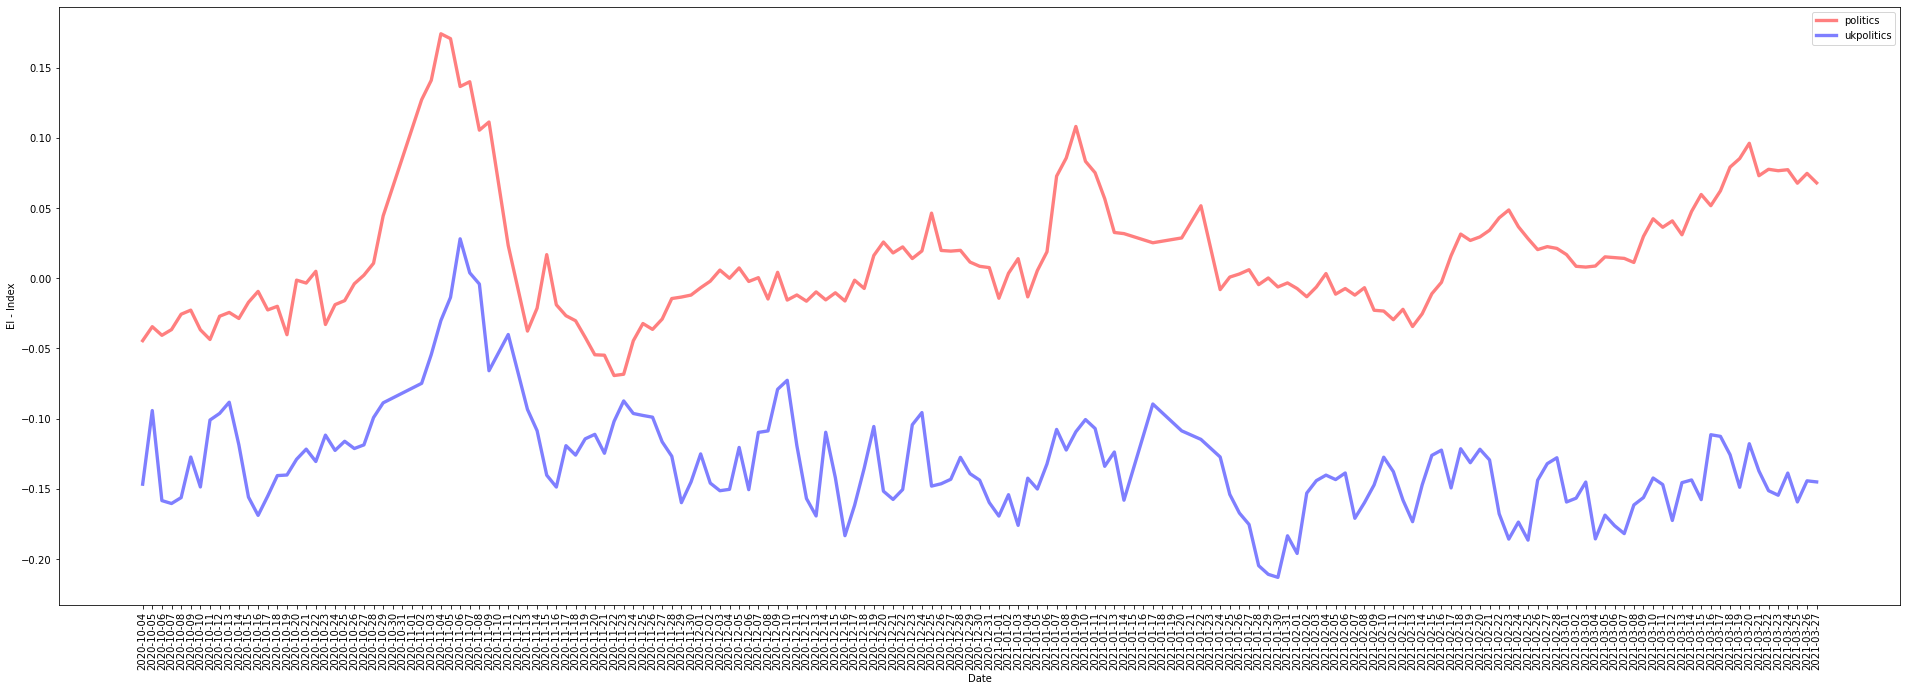

In [51]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(politics.keys(), politics.values(), c='red', lw=3.333, alpha=0.5, label='politics')
plt.plot(ukpolitics.keys(), ukpolitics.values(), c='blue', lw=3.333, alpha=0.5, label='ukpolitics')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

# Flip the Relation

In [78]:
pairs = set(politics_dt).intersection(set(conservative_dt))

In [79]:
politics = {}
i = 0
for date in politics_dt:
    if date in pairs:
        politics[date] = politics_ei[i]
    i += 1
conservative = {}
i = 0
for date in conservative_dt:
    if date in pairs:
        conservative[date] = conservative_ei[i]
    i += 1

In [54]:
covariance(politics.values(), conservative.values())

-0.0008349274455451711

In [55]:
correlation(politics.values(), conservative.values())

-0.2822453974776994

In [80]:
stats.pearsonr(list(politics.values()), list(conservative.values()))

(-0.28224539747769994, 0.0002992340831947469)

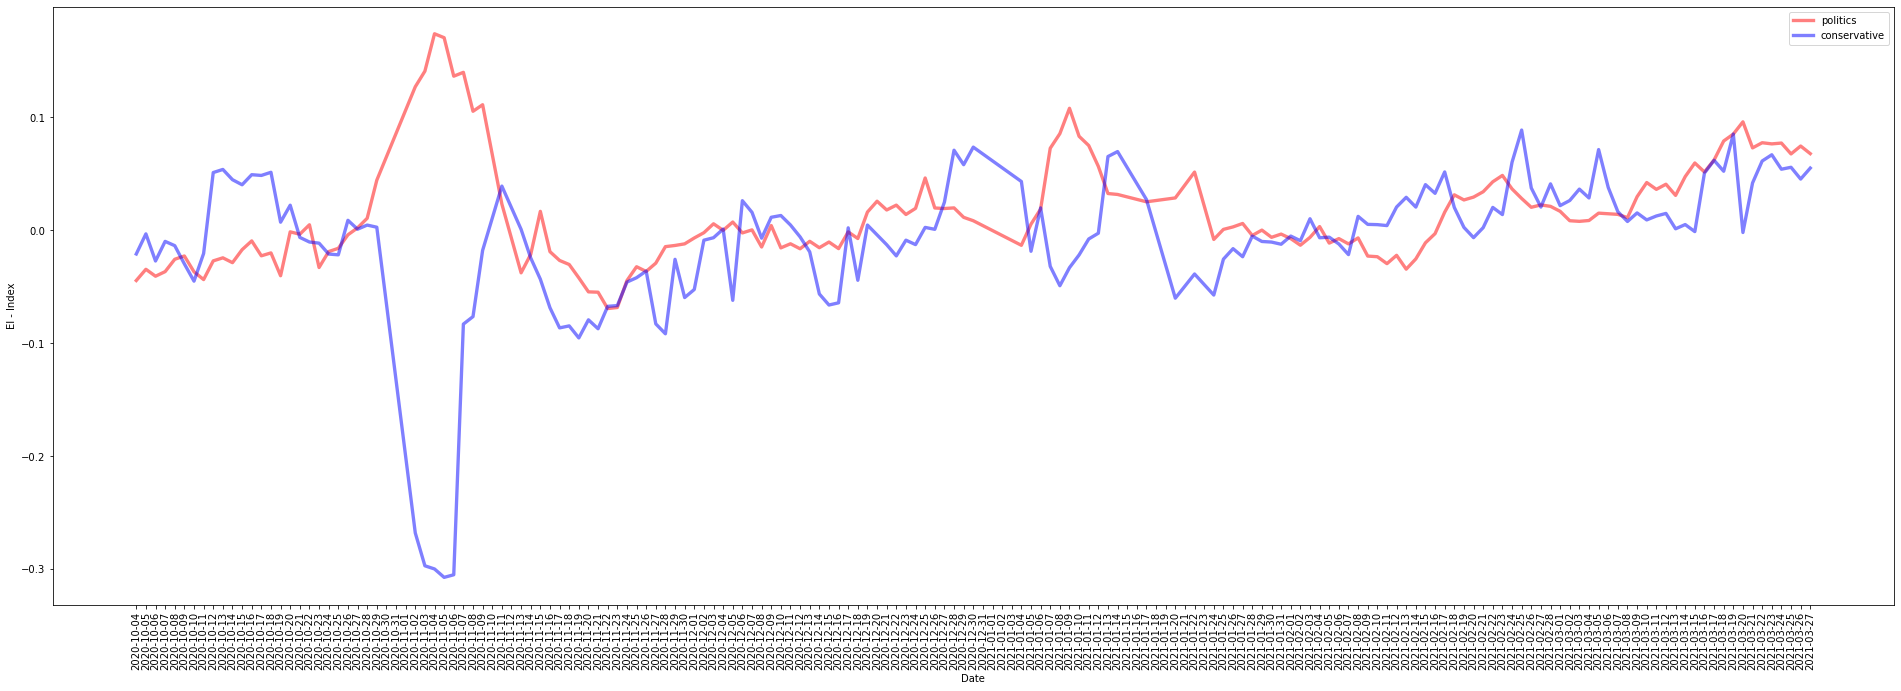

In [57]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(politics.keys(), politics.values(), c='red', lw=3.333, alpha=0.5, label='politics')
plt.plot(conservative.keys(), conservative.values(), c='blue', lw=3.333, alpha=0.5, label='conservative')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

In [82]:
pairs = set(conservative_dt).intersection(set(ukpolitics_dt))

In [83]:
conservative = {}
i = 0
for date in conservative_dt:
    if date in pairs:
        conservative[date] = conservative_ei[i]
    i += 1
ukpolitics = {}
i = 0
for date in ukpolitics_dt:
    if date in pairs:
        ukpolitics[date] = ukpolitics_ei[i]
    i += 1

In [60]:
covariance(conservative.values(), ukpolitics.values())

-0.0012194030253879604

In [61]:
correlation(conservative.values(), ukpolitics.values())

-0.4905645919790254

In [84]:
stats.pearsonr(list(conservative.values()), list(ukpolitics.values()))

(-0.49056459197902524, 9.686211608387332e-12)

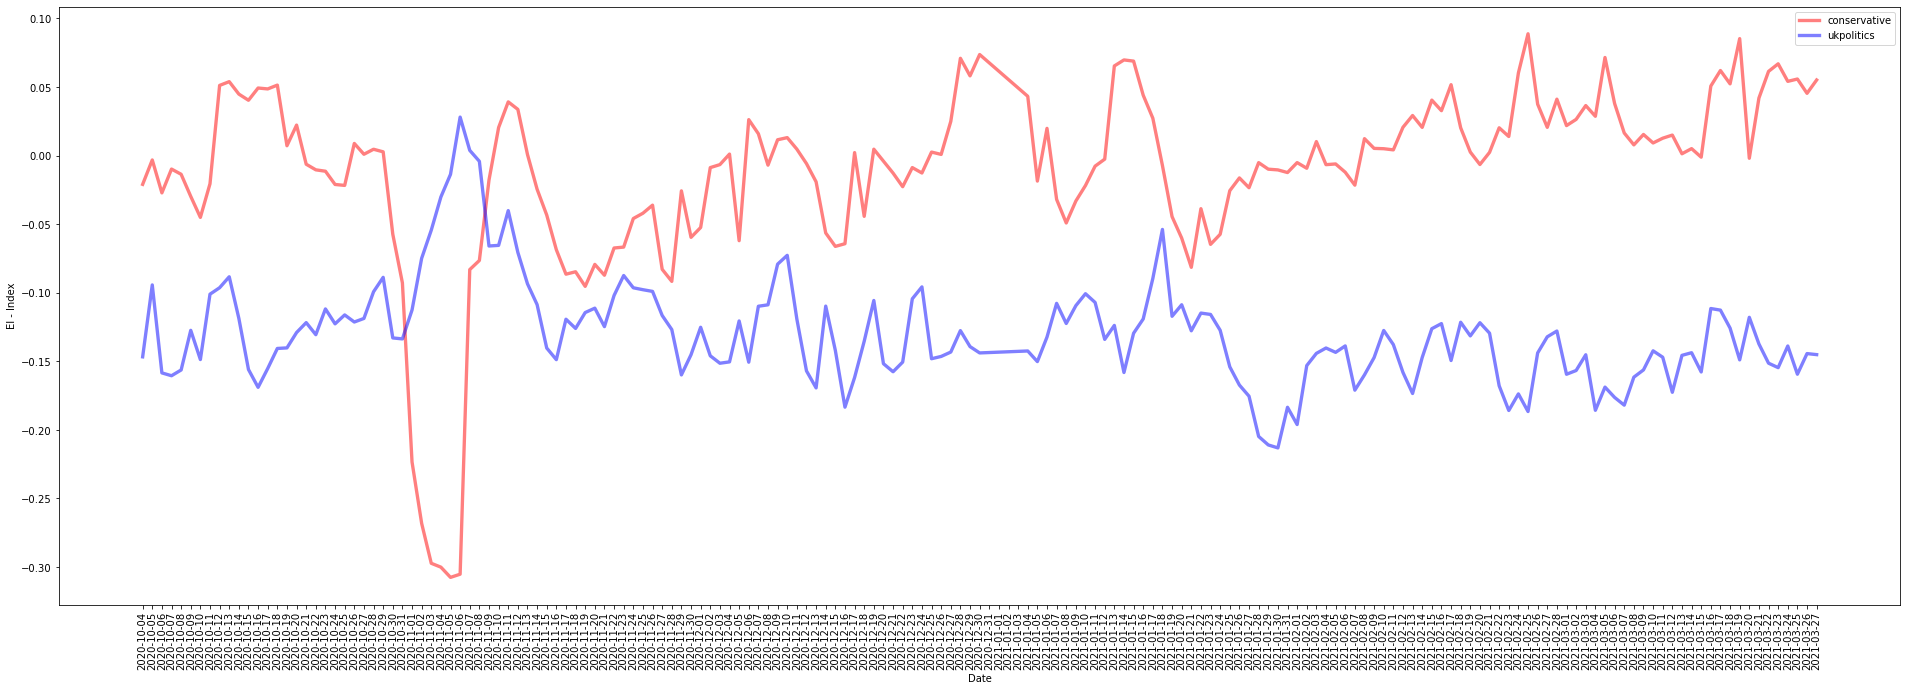

In [63]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(conservative.keys(), conservative.values(), c='red', lw=3.333, alpha=0.5, label='conservative')
plt.plot(ukpolitics.keys(), ukpolitics.values(), c='blue', lw=3.333, alpha=0.5, label='ukpolitics')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

In [85]:
pairs = set(politics_dt).intersection(set(neoliberal_dt))

In [86]:
politics = {}
i = 0
for date in politics_dt:
    if date in pairs:
        politics[date] = politics_ei[i]
    i += 1
neoliberal = {}
i = 0
for date in neoliberal_dt:
    if date in pairs:
        neoliberal[date] = neoliberal_ei[i]
    i += 1

In [66]:
covariance(politics.values(), neoliberal.values())

-0.0010632491337442

In [67]:
correlation(politics.values(), neoliberal.values())

-0.27568266359222315

In [87]:
stats.pearsonr(list(politics.values()), list(neoliberal.values()))

(-0.27568266359222315, 0.00047466423980284037)

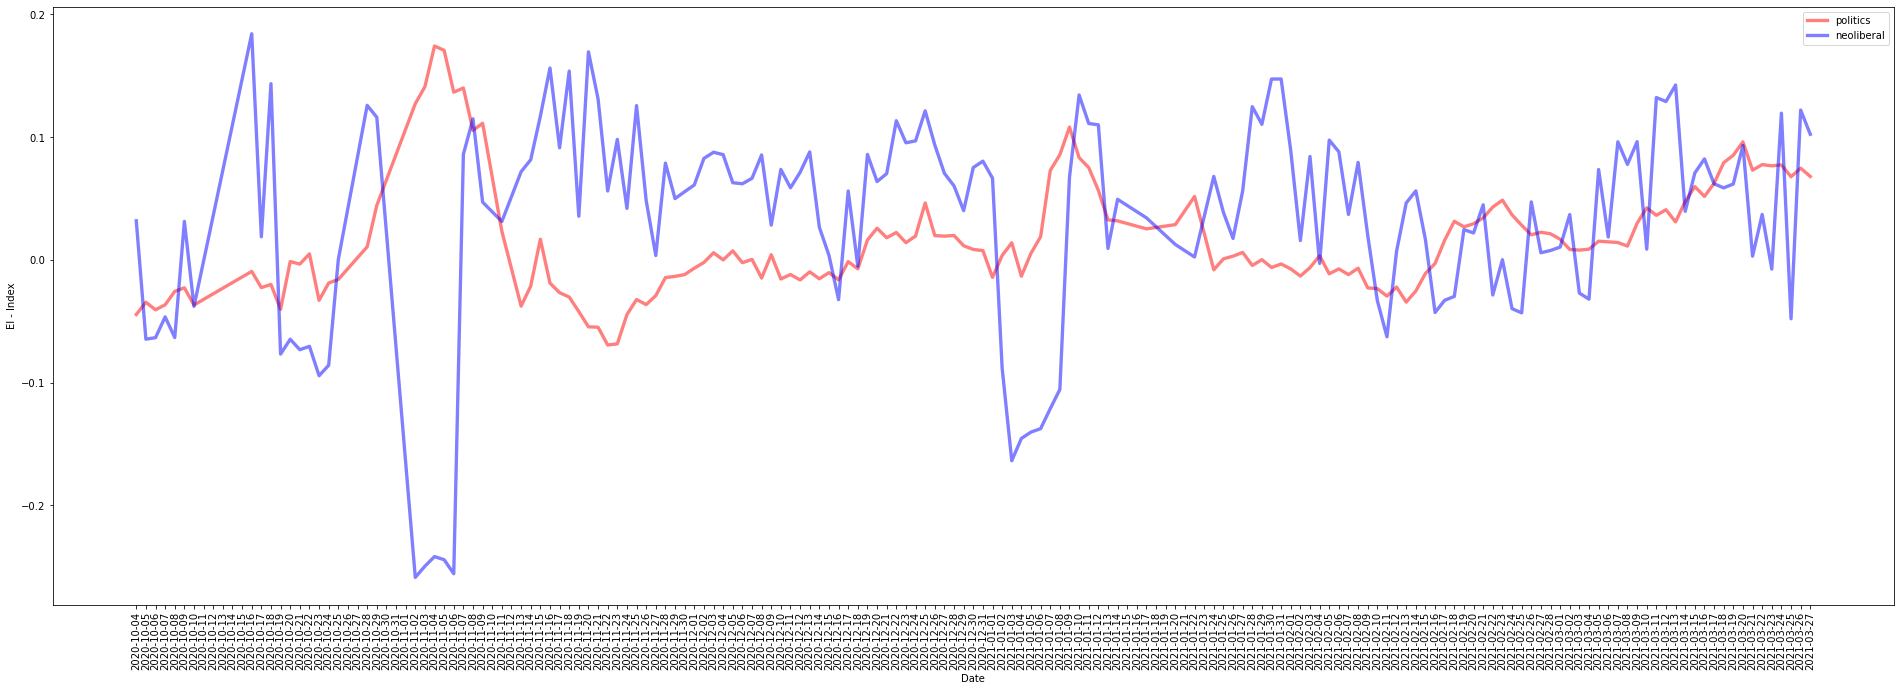

In [69]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(politics.keys(), politics.values(), c='red', lw=3.333, alpha=0.5, label='politics')
plt.plot(neoliberal.keys(), neoliberal.values(), c='blue', lw=3.333, alpha=0.5, label='neoliberal')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

In [88]:
pairs = set(neoliberal_dt).intersection(set(ukpolitics_dt))

In [89]:
neoliberal = {}
i = 0
for date in neoliberal_dt:
    if date in pairs:
        neoliberal[date] = neoliberal_ei[i]
    i += 1
ukpolitics = {}
i = 0
for date in ukpolitics_dt:
    if date in pairs:
        ukpolitics[date] = ukpolitics_ei[i]
    i += 1

In [72]:
covariance(neoliberal.values(), ukpolitics.values())

-0.000794970301788927

In [73]:
correlation(neoliberal.values(), ukpolitics.values())

-0.24197888118127897

In [90]:
stats.pearsonr(list(neoliberal.values()), list(ukpolitics.values()))

(-0.24197888118127892, 0.0015772244806000599)

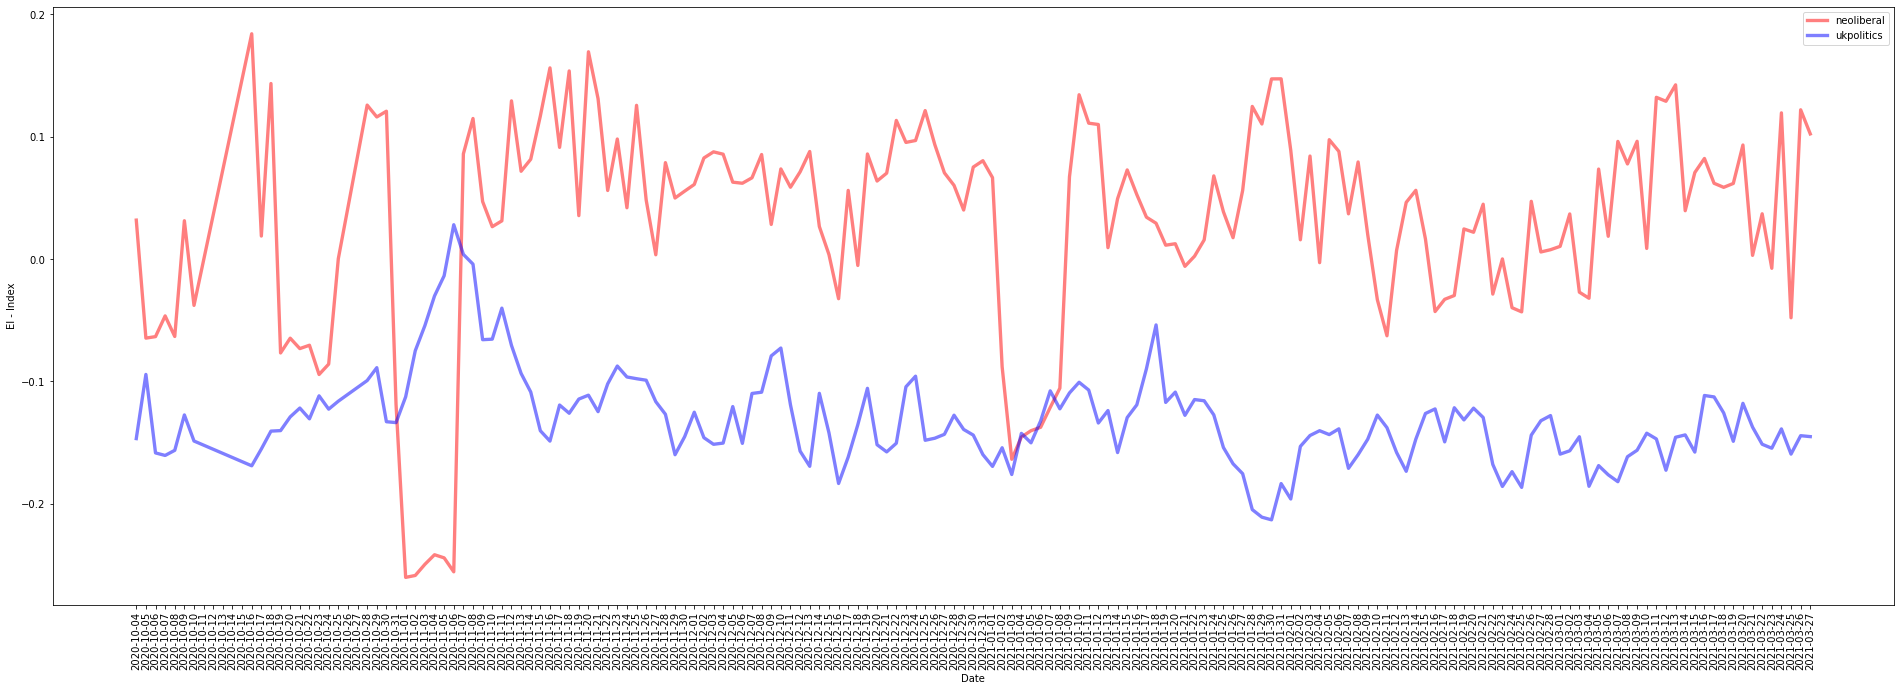

In [75]:
fig = plt.figure(figsize=(33,11))
plt.plot(_center_dates, [0 for _ in _center_dates], alpha=0)
plt.plot(neoliberal.keys(), neoliberal.values(), c='red', lw=3.333, alpha=0.5, label='neoliberal')
plt.plot(ukpolitics.keys(), ukpolitics.values(), c='blue', lw=3.333, alpha=0.5, label='ukpolitics')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('EI - Index')
plt.legend()

In [76]:
# from statsmodels.formula.api import ols

In [77]:
# df = pd.DataFrame({'x': range(len(guns_dt)), 'y': guns_ei})
# lm = ols("y ~ x", df).fit()
# print(lm.summary())